In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté.")
else:
    print("Aucun GPU détecté, l'entraînement se fera sur le CPU.")

Aucun GPU détecté, l'entraînement se fera sur le CPU.


In [6]:
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'
batch_size = 32
epochs_list = [5, 10, 20]
padding_size = 20

In [34]:
# Fonction pour charger les données
def load_data(data_dir1, data_dir2, limit=100):
    print("Chargement des données...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Échec de la lecture de {img}. Passage à l'image suivante.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Chargement des données terminé.")
    return np.array(data, dtype=object)

# Appel de la fonction load_data
train_data = load_data(data_dir1, data_dir2, limit=100)

Chargement des données...
Chargement des données terminé.


In [36]:
# Fonction pour séparer les caractéristiques et les labels
def separate_features_labels(data):
    print("Séparation des caractéristiques et des labels...")
    features = []
    labels = []
    for img, label in data:
        features.append(img)
        labels.append(label)
    print("Séparation terminée.")
    return np.array(features), np.array(labels)

# Appel de la fonction separate_features_labels
x_data, y_data = separate_features_labels(train_data)

# Fonction pour prétraiter les images
def preprocess_image(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0  # Normalisation après redimensionnement
    return image

# Fonction pour prétraiter les données
def preprocess_data(data):
    print("Prétraitement des données...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        print(f"Traitement de l'image {idx+1}/{len(data)}")
        img = preprocess_image(img)
        processed_data.append([img, label])
    print("Prétraitement des données terminé.")
    return np.array(processed_data, dtype=object)

# Appel de la fonction preprocess_data
train_data = preprocess_data(train_data)

Séparation des caractéristiques et des labels...
Séparation terminée.
Prétraitement des données...
Traitement de l'image 1/200
Traitement de l'image 2/200
Traitement de l'image 3/200
Traitement de l'image 4/200
Traitement de l'image 5/200
Traitement de l'image 6/200
Traitement de l'image 7/200
Traitement de l'image 8/200
Traitement de l'image 9/200
Traitement de l'image 10/200
Traitement de l'image 11/200
Traitement de l'image 12/200
Traitement de l'image 13/200
Traitement de l'image 14/200
Traitement de l'image 15/200
Traitement de l'image 16/200
Traitement de l'image 17/200
Traitement de l'image 18/200
Traitement de l'image 19/200
Traitement de l'image 20/200
Traitement de l'image 21/200
Traitement de l'image 22/200
Traitement de l'image 23/200
Traitement de l'image 24/200
Traitement de l'image 25/200
Traitement de l'image 26/200
Traitement de l'image 27/200
Traitement de l'image 28/200
Traitement de l'image 29/200
Traitement de l'image 30/200
Traitement de l'image 31/200
Traitement 

In [38]:
# Prétraitement des données : redimensionnement et conversion en 3 canaux
print("Redimensionnement et conversion des données en 3 canaux...")
x_data = x_data.reshape(-1, img_size, img_size, 1)
x_data = np.concatenate([x_data, x_data, x_data], axis=-1)  # Convertir en 3 canaux

Redimensionnement et conversion des données en 3 canaux...


In [40]:
# Division des données en ensembles d'entraînement et de validation
print("Division des données en ensembles d'entraînement et de validation...")
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

Division des données en ensembles d'entraînement et de validation...


In [42]:
def create_model():
    print("Création du modèle CNN...")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    print("Modèle CNN créé et compilé.")
    return model

create_model()

Création du modèle CNN...
Modèle CNN créé et compilé.


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_5, built=True>

In [44]:
# Fonction pour créer le générateur de données
def create_datagen():
    print("Création du générateur de données...")
    return ImageDataGenerator(
        zoom_range=0.1,
        shear_range=0.1
    )

# Appel de la fonction create_datagen
datagen = create_datagen()

Création du générateur de données...


In [46]:
# Fonction pour évaluer le modèle
def evaluate_model(model, x_val, y_val):
    print("Évaluation du modèle...")
    scores = model.evaluate(x_val, y_val, verbose=0)
    print(f"Précision de validation : {scores[1]*100:.2f}%")
    print(f"Perte de validation : {scores[0]:.4f}")

    # Matrice de confusion
    y_pred = (model.predict(x_val) > 0.5).astype("int32")
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Réel')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion')
    plt.show()

    # Rapport de classification
    cr = classification_report(y_val, y_pred, target_names=['PNEUMONIA', 'NORMAL'])
    print("Rapport de Classification:\n", cr)

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (aire = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Caractéristique de Fonctionnement du Récepteur')
    plt.legend(loc="lower right")
    plt.show()

In [48]:
# Fonction pour visualiser les courbes d'apprentissage
def plot_learning_curves(history):
    print("Visualisation des courbes d'apprentissage...")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Perte d\'entraînement')
    plt.plot(history.history['val_loss'], label='Perte de validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.title('Perte')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
    plt.plot(history.history['val_accuracy'], label='Précision de validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.title('Précision')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [50]:
# Fonction pour afficher les prédictions
def display_predictions(model, x_val, y_val):
    print("Affichage des prédictions...")
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype("int32")
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_val[i].reshape(img_size, img_size, 3))
        pred_label = predictions[i][0]
        true_label = y_val[i]
        plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.show()
    print("Affichage des prédictions terminé.")


Validation croisée pour choisir le nombre optimal d'époques...

Entraînement avec 5 époques...
Création du modèle CNN...
Modèle CNN créé et compilé.
Création du générateur de données...
Epoch 1/5


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step - accuracy: 0.5686 - loss: 278.3983 - val_accuracy: 0.4750 - val_loss: 11.4714 - learning_rate: 0.0010
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.5676 - loss: 6.1223 - val_accuracy: 0.8500 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.6611 - loss: 0.7403 - val_accuracy: 0.5500 - val_loss: 1.1578 - learning_rate: 0.0010
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.5372 - loss: 1.4313 - val_accuracy: 0.9250 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 526ms/step - accuracy: 0.7343 - loss: 0.5903 - val_accuracy: 0.9750 - val_loss: 0.4712 - learning_rate: 0.0010
Évaluation du modèle...
Précision de validation : 97.50%
Perte de validation : 0.4712
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step


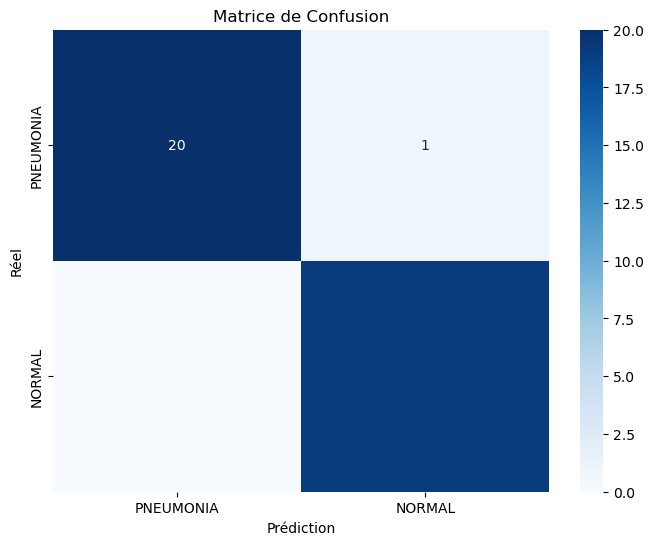

Rapport de Classification:
               precision    recall  f1-score   support

   PNEUMONIA       1.00      0.95      0.98        21
      NORMAL       0.95      1.00      0.97        19

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



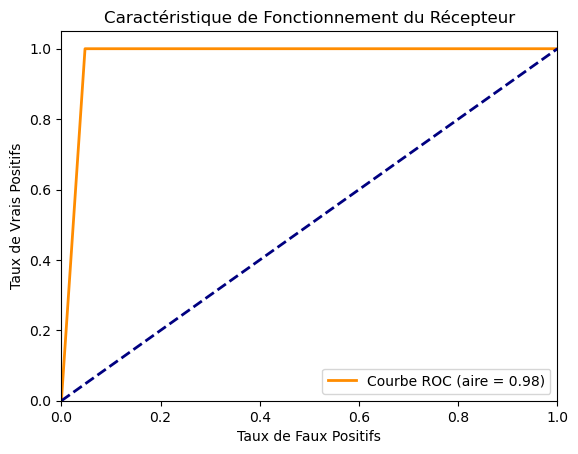

Visualisation des courbes d'apprentissage...


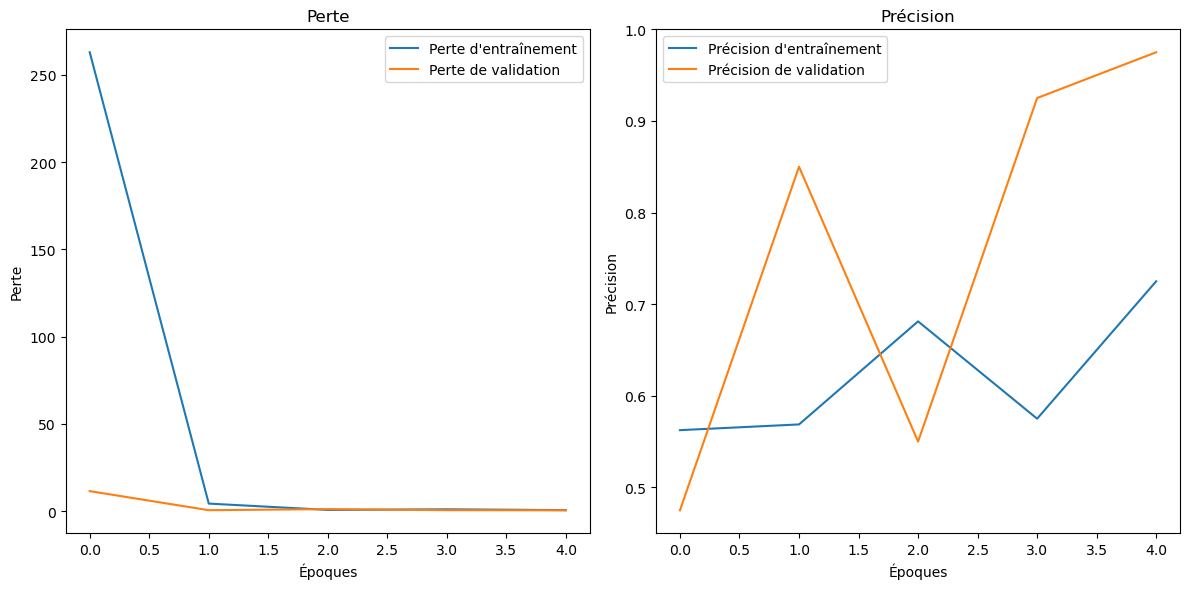


Entraînement avec 10 époques...
Création du modèle CNN...
Modèle CNN créé et compilé.
Création du générateur de données...


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step - accuracy: 0.5138 - loss: 379.1914 - val_accuracy: 0.5250 - val_loss: 19.5998 - learning_rate: 0.0010
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.5049 - loss: 10.9264 - val_accuracy: 0.5250 - val_loss: 3.0957 - learning_rate: 0.0010
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step - accuracy: 0.5391 - loss: 2.2794 - val_accuracy: 0.4750 - val_loss: 0.8450 - learning_rate: 0.0010
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 521ms/step - accuracy: 0.4916 - loss: 0.9258 - val_accuracy: 0.6500 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.5579 - loss: 0.6606 - val_accuracy: 0.5750 - val_loss: 0.6231 - learning_rate: 0.0010
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.6431 - loss: 0.6254 - val_accuracy: 0.8000 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.6735 - loss: 0.6255 - val_accuracy: 0.8500

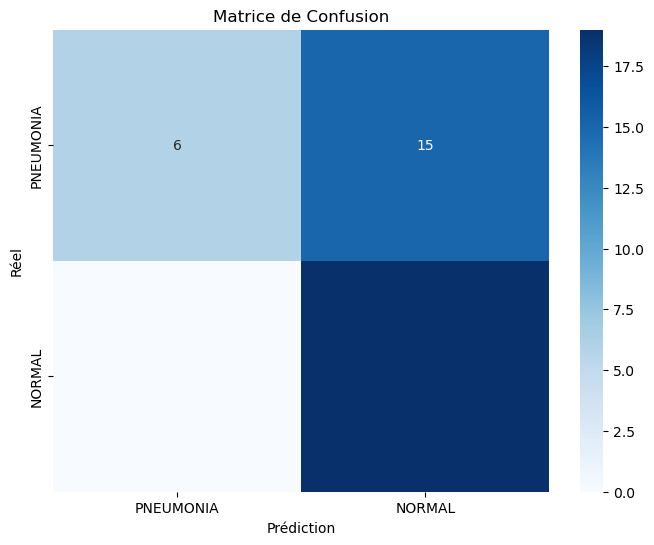

Rapport de Classification:
               precision    recall  f1-score   support

   PNEUMONIA       1.00      0.29      0.44        21
      NORMAL       0.56      1.00      0.72        19

    accuracy                           0.62        40
   macro avg       0.78      0.64      0.58        40
weighted avg       0.79      0.62      0.57        40



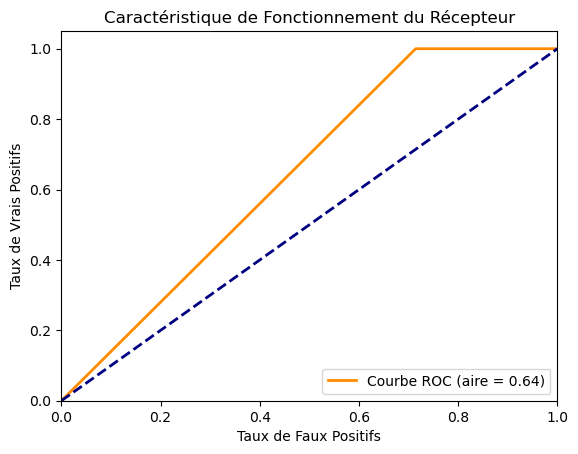

Visualisation des courbes d'apprentissage...


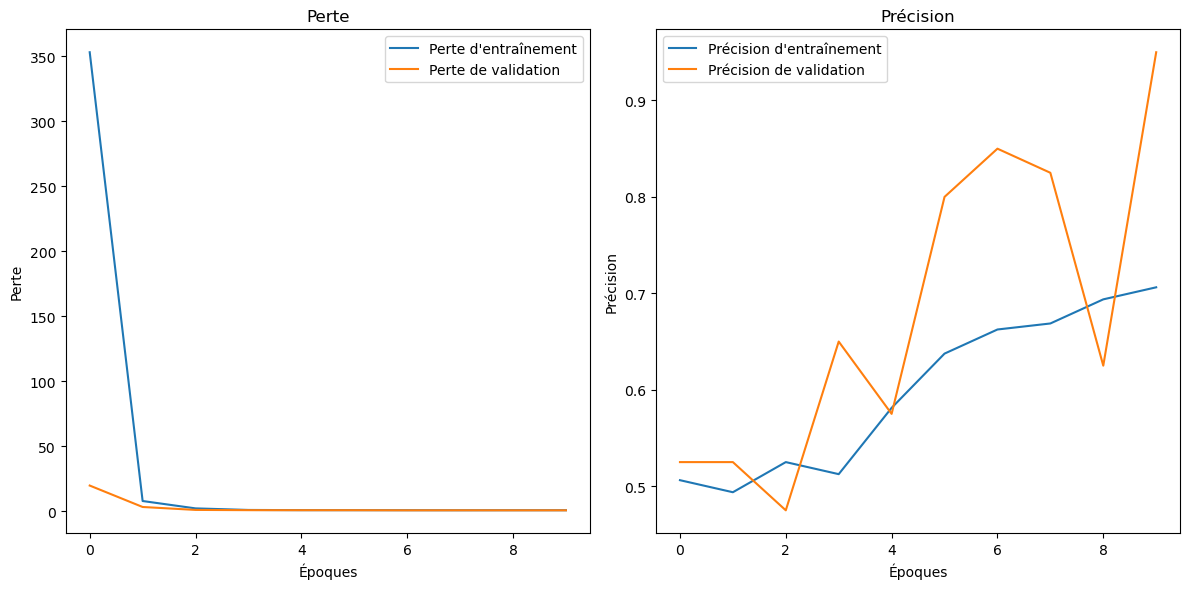


Entraînement avec 20 époques...
Création du modèle CNN...
Modèle CNN créé et compilé.
Création du générateur de données...


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 670ms/step - accuracy: 0.4415 - loss: 167.0542 - val_accuracy: 0.4750 - val_loss: 3.2961 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 524ms/step - accuracy: 0.5467 - loss: 6.5638 - val_accuracy: 0.5750 - val_loss: 1.1313 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - accuracy: 0.4706 - loss: 1.5702 - val_accuracy: 0.4750 - val_loss: 1.0124 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.6865 - loss: 0.6834 - val_accuracy: 0.7000 - val_loss: 0.5117 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.7015 - loss: 0.5708 - val_accuracy: 0.8250 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.7590 - loss: 0.4760 - val_accuracy: 0.8750 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.7945 - loss: 0.4431 - val_accuracy: 0.8250 -

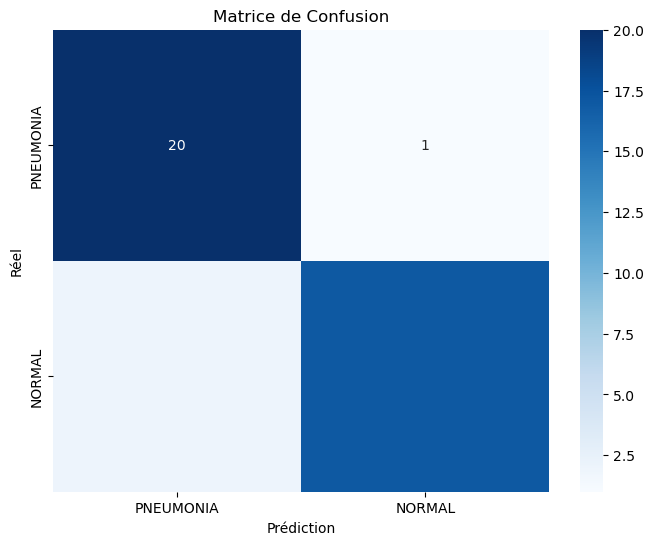

Rapport de Classification:
               precision    recall  f1-score   support

   PNEUMONIA       0.91      0.95      0.93        21
      NORMAL       0.94      0.89      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40



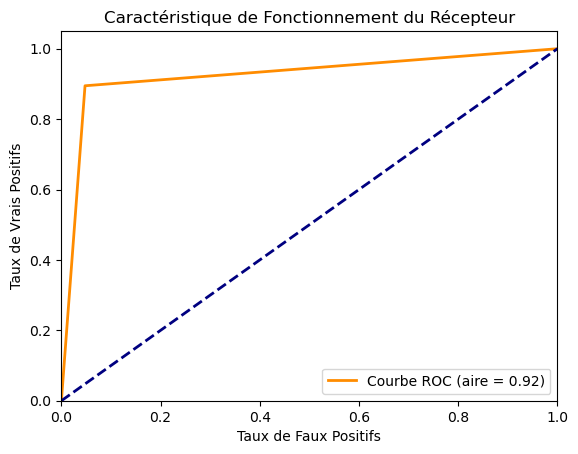

Visualisation des courbes d'apprentissage...


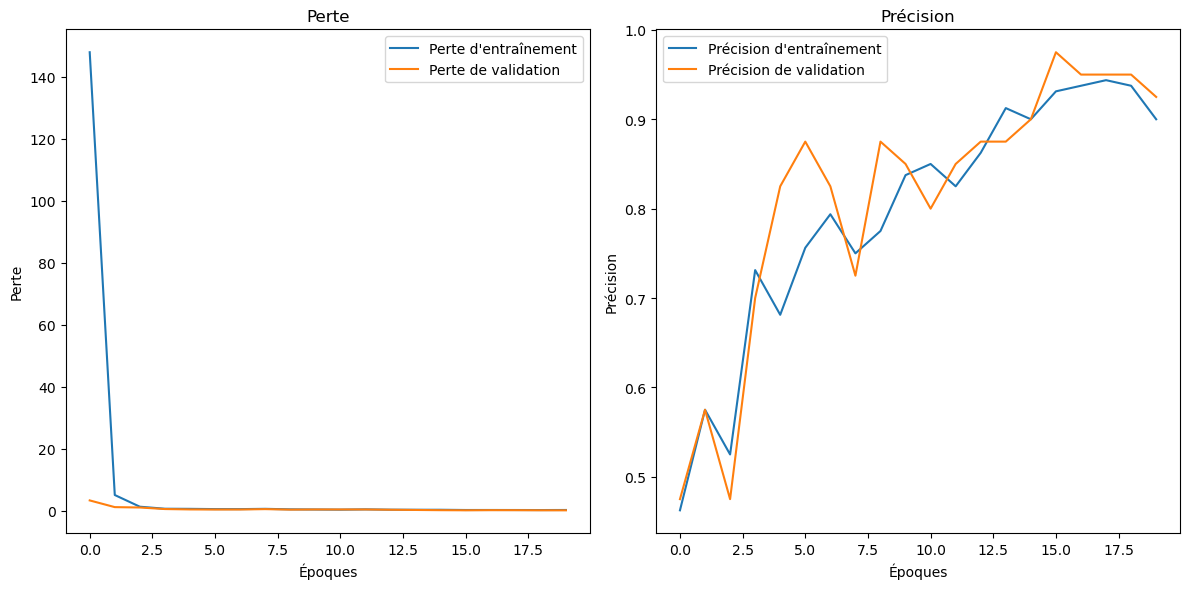


Le nombre optimal d'époques est 5 avec une précision de validation de 97.50%.


In [52]:
# Validation croisée pour choisir le nombre optimal d'époques
print("\nValidation croisée pour choisir le nombre optimal d'époques...")
best_accuracy = 0
best_epochs = 0

for epochs in epochs_list:
    print(f"\nEntraînement avec {epochs} époques...")
    model = create_model()
    datagen = create_datagen()
    datagen.fit(x_train)
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001), 
                                   EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Évaluation du modèle
    evaluate_model(model, x_val, y_val)
    
    # Visualisation des courbes d'apprentissage
    plot_learning_curves(history)
    
    # Sélection du meilleur nombre d'époques
    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epochs = epochs

print(f"\nLe nombre optimal d'époques est {best_epochs} avec une précision de validation de {best_accuracy*100:.2f}%.")


In [54]:
# Entraînement final avec le nombre optimal d'époques
print("\nEntraînement final du modèle avec le nombre optimal d'époques...")
datagen = create_datagen()
datagen.fit(x_train)
final_model = create_model()
history = final_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          epochs=best_epochs,
                          validation_data=(x_val, y_val),
                          callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001), 
                                     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Entraînement final du modèle avec le nombre optimal d'époques...
Création du générateur de données...
Création du modèle CNN...


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modèle CNN créé et compilé.
Epoch 1/5


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 838ms/step - accuracy: 0.4031 - loss: 156.4609 - val_accuracy: 0.5250 - val_loss: 11.3714 - learning_rate: 0.0010
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.5610 - loss: 8.6502 - val_accuracy: 0.5000 - val_loss: 0.9378 - learning_rate: 0.0010
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - accuracy: 0.6198 - loss: 1.2159 - val_accuracy: 0.6750 - val_loss: 0.5970 - learning_rate: 0.0010
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.7144 - loss: 0.5598 - val_accuracy: 0.8000 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - accuracy: 0.6786 - loss: 0.6241 - val_accuracy: 0.8750 - val_loss: 0.3920 - learning_rate: 0.0010


Évaluation finale...
Évaluation du modèle...
Précision de validation : 87.50%
Perte de validation : 0.3920
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step


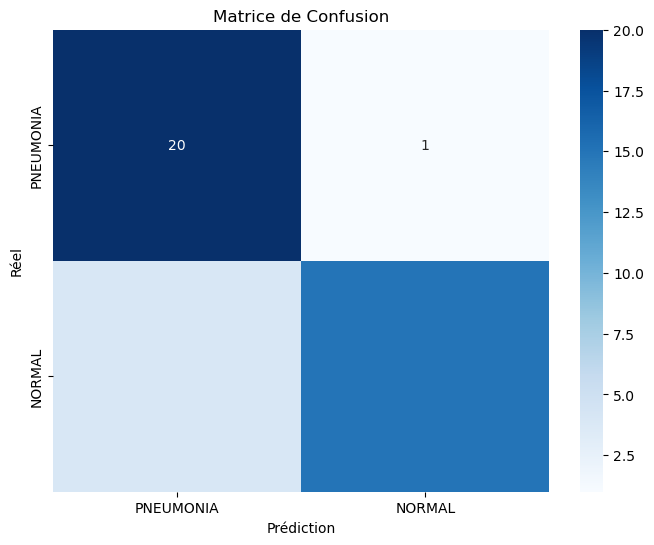

Rapport de Classification:
               precision    recall  f1-score   support

   PNEUMONIA       0.83      0.95      0.89        21
      NORMAL       0.94      0.79      0.86        19

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40



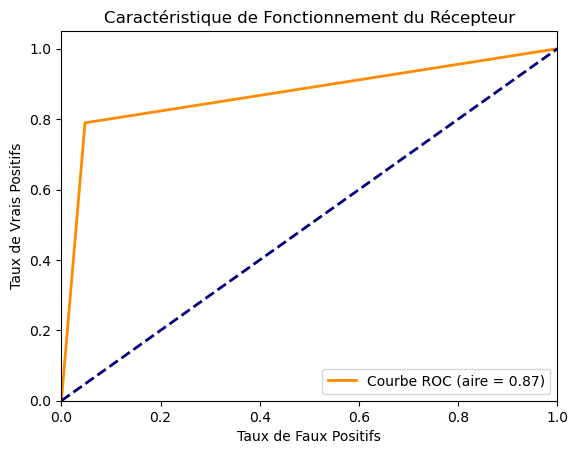

In [56]:
print("Évaluation finale...")
evaluate_model(final_model, x_val, y_val)

Affichage des prédictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


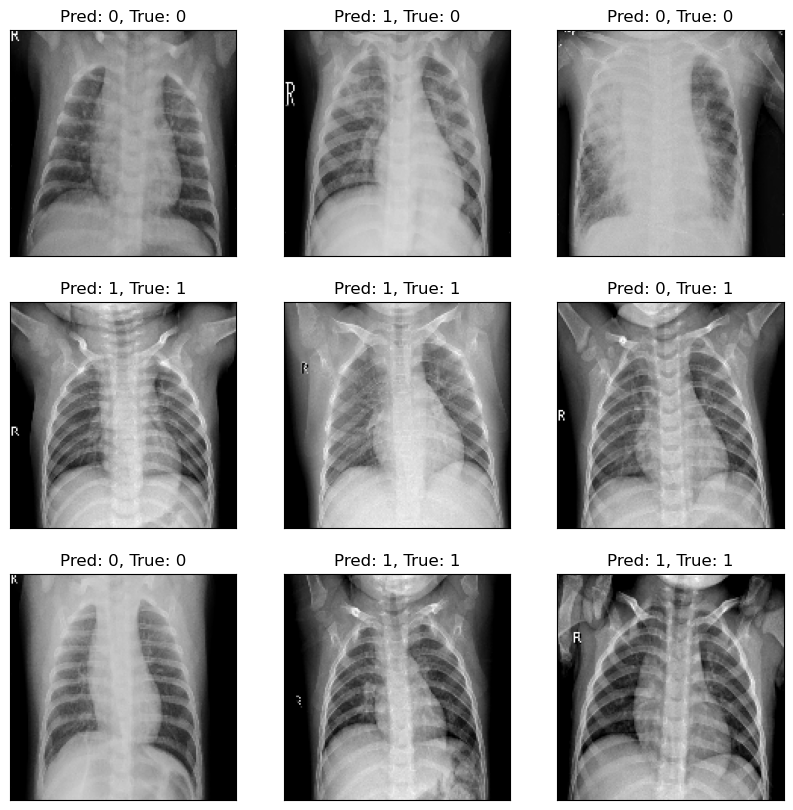

Affichage des prédictions terminé.


In [58]:
# Visualisation des prédictions
display_predictions(final_model, x_val, y_val)

In [60]:
# Sauvegarde du modèle
final_model.save('final_cnn_model.h5')
print("Modèle sauvegardé sous 'final_cnn_model.h5'.")

Modèle sauvegardé sous 'final_cnn_model.h5'.
